# Проект промышленность

## Imports


In [90]:
!pip3 install -q catboost

In [91]:
from sqlalchemy import create_engine
import pandas as pd 
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.layers import  Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

## Data base connection

In [92]:

db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-final' # название базы данных,
} 

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)
engine = create_engine(connection_string)

Проведем первичное исследование таблиц

In [93]:
def select_all(table_name):
  query = """
  select *
  from {}
  """.format(table_name)
  table = pd.read_sql_query(query, con=engine) 
  print(table.shape)
  return table

In [94]:
data_arc = select_all('steel.data_arc')
data_arc.head()

(14876, 5)


,key,BeginHeat,EndHeat,ActivePower,ReactivePower
0,1,11:02:14,11:06:02,0.976059,0.687084
1,1,11:07:28,11:10:33,0.805607,0.520285
2,1,11:11:44,11:14:36,0.744363,0.498805
3,1,11:18:14,11:24:19,1.659363,1.062669
4,1,11:26:09,11:28:37,0.692755,0.414397


In [95]:
data_bulk = select_all('steel.data_bulk')
data_bulk = data_bulk.fillna(0)
data_bulk.head()

(3129, 16)


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [96]:
data_bulk_time = select_all('steel.data_bulk_time')
data_bulk_time = data_bulk_time.fillna(0)
data_bulk_time.columns = [column + ' time' if column != 'key' else column for column in data_bulk_time.columns]
data_bulk_time.head()

(3129, 16)


,key,Bulk 1 time,Bulk 2 time,Bulk 3 time,Bulk 4 time,Bulk 5 time,Bulk 6 time,Bulk 7 time,Bulk 8 time,Bulk 9 time,Bulk 10 time,Bulk 11 time,Bulk 12 time,Bulk 13 time,Bulk 14 time,Bulk 15 time
0,1,0,0,0,11:21:30,0,0,0,0,0,0,0,11:03:52,0,11:03:52,11:03:52
1,2,0,0,0,11:46:38,0,0,0,0,0,0,0,11:40:20,0,11:40:20,11:40:20
2,3,0,0,0,12:31:06,0,0,0,0,0,0,0,12:09:40,0,12:09:40,12:09:40
3,4,0,0,0,12:48:43,0,0,0,0,0,0,0,12:41:24,0,12:41:24,12:41:24
4,5,0,0,0,13:18:50,0,0,0,0,0,0,0,13:12:56,0,13:12:56,13:12:56


In [97]:
data_gas = select_all('steel.data_gas')
data_gas.head()

(3239, 2)


,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [98]:
data_temp = select_all('steel.data_temp')
data_temp.head()

(15907, 3)


,key,MesaureTime,Temperature
0,1,11:16:18,1571.0
1,1,11:25:53,1604.0
2,1,11:29:11,1618.0
3,1,11:30:01,1601.0
4,1,11:30:39,1613.0


In [99]:
data_wire = select_all('steel.data_wire')
data_wire = data_wire.fillna(0)
data_wire.head()

(3081, 10)


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [100]:
data_wire_time = select_all('steel.data_wire_time')
data_wire_time = data_wire_time.fillna(0)
data_wire_time.columns = [column + ' time' if column != 'key' else column for column in data_wire_time.columns]
data_wire_time.head()

(3081, 10)


,key,Wire 1 time,Wire 2 time,Wire 3 time,Wire 4 time,Wire 5 time,Wire 6 time,Wire 7 time,Wire 8 time,Wire 9 time
0,1,11:11:41,0,0,0,0,0,0,0,0
1,2,11:46:10,0,0,0,0,0,0,0,0
2,3,12:13:47,0,0,0,0,0,0,0,0
3,4,12:48:05,0,0,0,0,0,0,0,0
4,5,13:18:15,13:32:06,0,0,0,0,0,0,0


Заменим пропущенные значения на 0, потому что здесь явно подразумевается отсутствие значения

Итак, все таблицы существуют, общий ключ для связи - номер партии, тоже есть

## EDA

Нужно найти сколько времени прошло между первым и последним замером температуры.

In [101]:
query = """
select key,
     (last_value("MesaureTime") over(partition by key order by  "MesaureTime" desc) - 
     first_value("MesaureTime") over(partition by key order by "MesaureTime" asc)) as time
from steel.data_temp
  """
time_table = pd.read_sql_query(query, con=engine) 
print(time_table.shape)
time_table.head(10)

(15907, 2)


,key,time
0,1,0 days 00:00:00
1,1,0 days 00:09:35
2,1,0 days 00:12:53
3,1,0 days 00:13:43
4,1,0 days 00:14:21
5,2,0 days 00:00:00
6,2,0 days 00:00:33
7,2,0 days 00:12:11
8,2,0 days 00:18:23
9,2,0 days 00:20:57


Суммарное время нагрева электродами, то есть сумму значений по всем промежуткам между запусками нагрева электродами. Количество запусков нагрева электродами. Среднее соотношение потребления активной и реактивной мощности.

In [102]:
query = """
select key,
  sum("EndHeat" - "BeginHeat") over(partition by key) as diff,
  count(key) over(partition by key) as counts,
  avg("ActivePower" / "ReactivePower") over(partition by key) as avg_power
from steel.data_arc
  """
temp_table = pd.read_sql_query(query, con=engine) 
print(temp_table.shape)
temp_table.head(10)

(14876, 4)


,key,diff,counts,avg_power
0,1,0 days 00:18:18,5,1.538898
1,1,0 days 00:18:18,5,1.538898
2,1,0 days 00:18:18,5,1.538898
3,1,0 days 00:18:18,5,1.538898
4,1,0 days 00:18:18,5,1.538898
5,2,0 days 00:13:31,4,1.551834
6,2,0 days 00:13:31,4,1.551834
7,2,0 days 00:13:31,4,1.551834
8,2,0 days 00:13:31,4,1.551834
9,3,0 days 00:10:55,5,1.583120


In [103]:
stats_data = temp_table.merge(time_table, on='key', how='right')
print(stats_data.shape)
stats_data.head()

(78317, 5)


,key,diff,counts,avg_power,time
0,1,0 days 00:18:18,5.0,1.538898,0 days
1,1,0 days 00:18:18,5.0,1.538898,0 days
2,1,0 days 00:18:18,5.0,1.538898,0 days
3,1,0 days 00:18:18,5.0,1.538898,0 days
4,1,0 days 00:18:18,5.0,1.538898,0 days


In [104]:
stats_data.isna().sum()

key          0
diff         2
counts       2
avg_power    2
time         0
dtype: int64

In [105]:
stats_data.drop('key', axis=1).describe()

,diff,counts,avg_power,time
count,78315,78315.000000,78315.000000,78317
mean,0 days 00:04:28.824682372,5.573224,1.359418,0 days 00:44:12.836753195
std,0 days 02:07:01.065254782,2.043837,0.139002,0 days 02:51:50.825711078
min,-1 days +00:05:47,1.000000,0.676106,0 days 00:00:00
25%,0 days 00:11:21,4.000000,1.293666,0 days 00:07:39
50%,0 days 00:14:44,5.000000,1.375723,0 days 00:19:04
75%,0 days 00:18:35,6.000000,1.445129,0 days 00:31:42
max,0 days 01:09:49,16.000000,1.782164,0 days 23:56:53


**Рассмотрим таблицу с электродами**

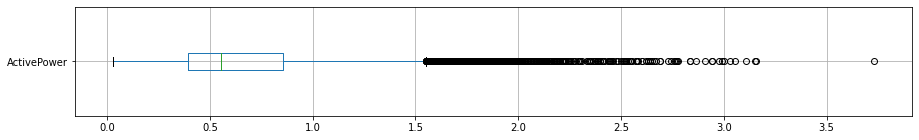

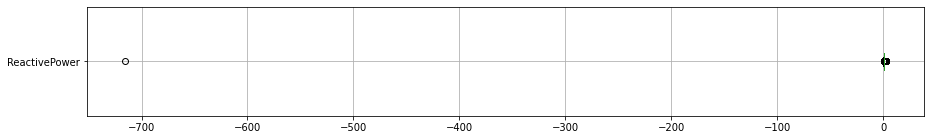

In [106]:
plt.figure(figsize=(15, 2))
data_arc.boxplot("ActivePower", vert=False)
plt.show()

plt.figure(figsize=(15, 2))
data_arc.boxplot('ReactivePower', vert=False)
plt.show()

Итак, можно наблюдать множество выбросов в значениях реактивной 

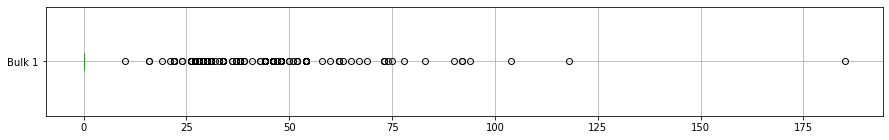

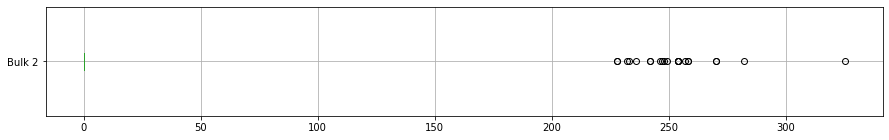

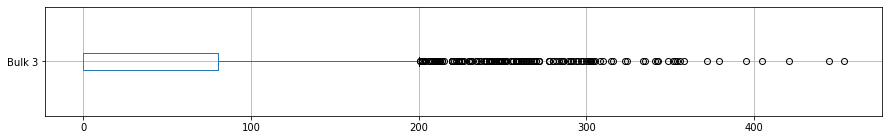

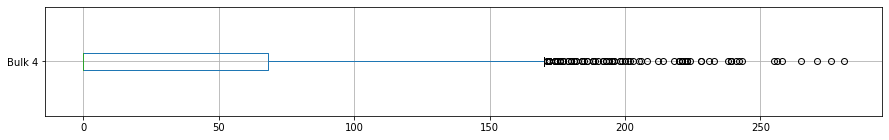

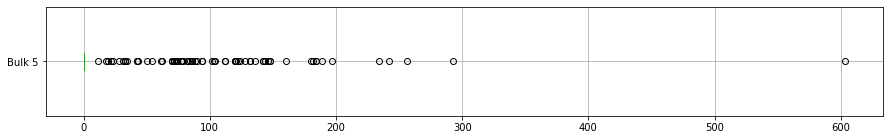

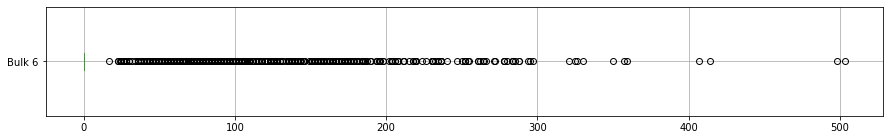

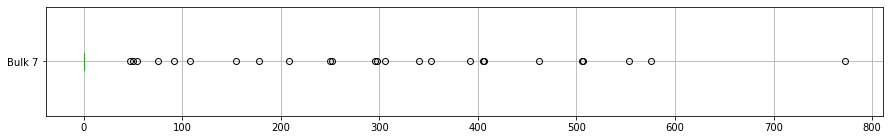

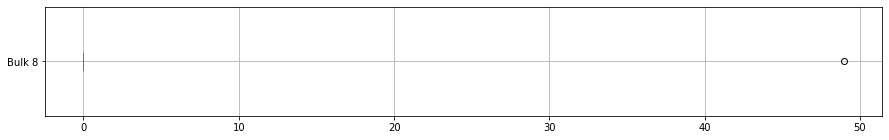

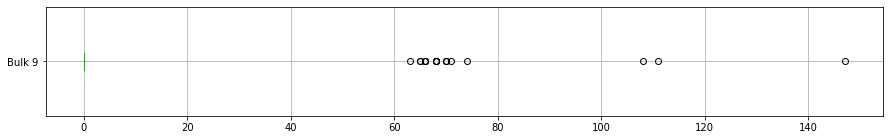

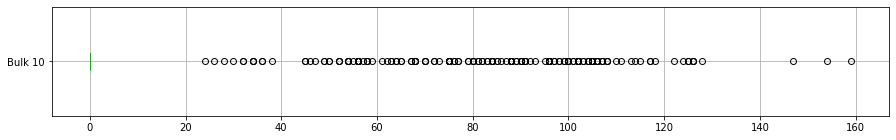

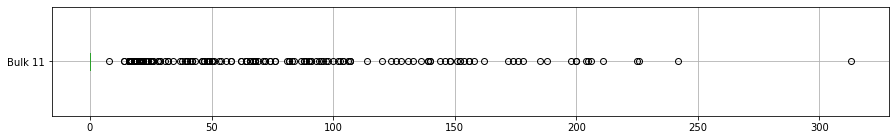

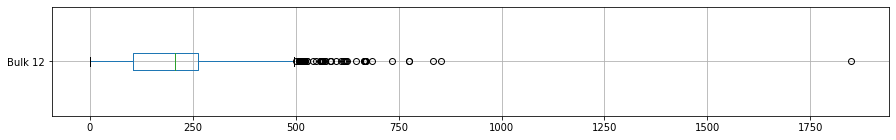

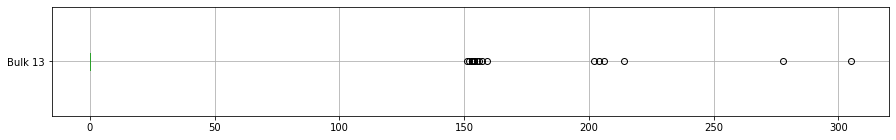

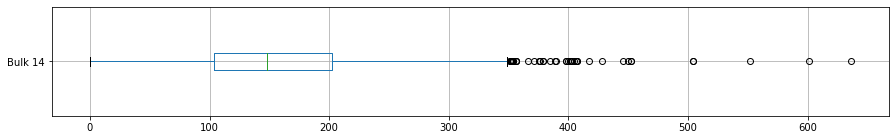

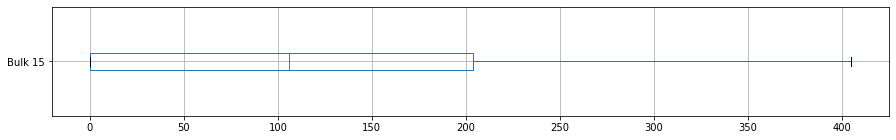

In [107]:
for column in data_bulk.drop('key', axis=1).columns:
  plt.figure(figsize=(15, 2))
  data_bulk.boxplot(column, vert=False)
  plt.show()

Итак, почти во всех признаках присутсвуют выбросы. Столбцы Bulk15, Bulk8 необходимо удалить ибо в них присутсвуют выбросы

**Рассмотрим таблицу с объёмом подаваемых проволочных материалов**

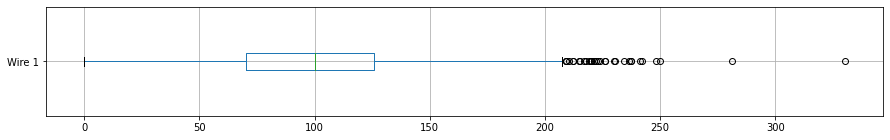

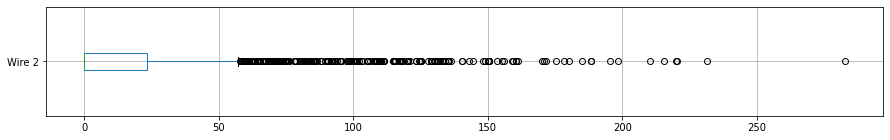

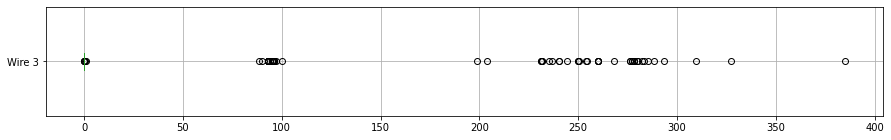

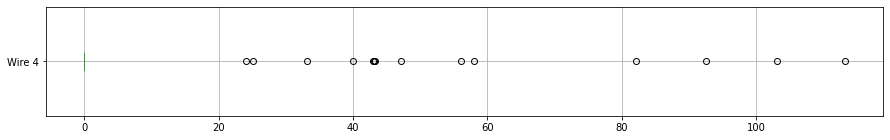

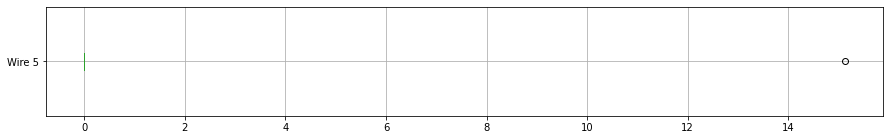

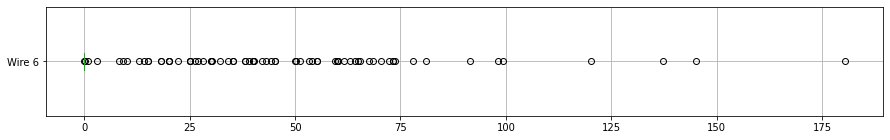

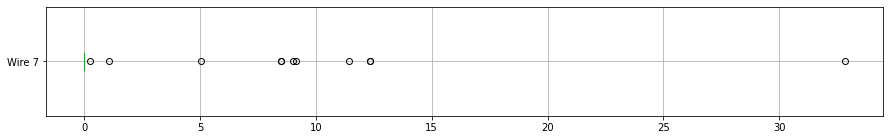

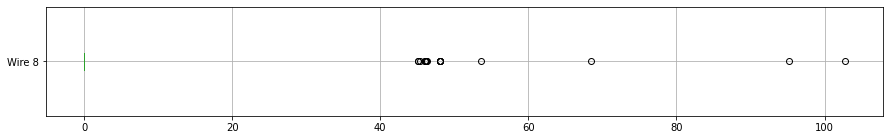

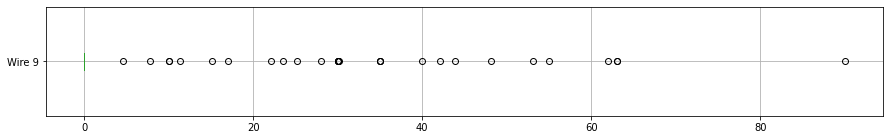

In [108]:
for column in data_wire.drop('key', axis=1).columns:
  plt.figure(figsize=(15, 2))
  data_wire.boxplot(column, vert=False)
  plt.show()

Столбцы wire1, Wire2, Wire5 нужно удалить 

**Рассмотрим таблицу с температурой**

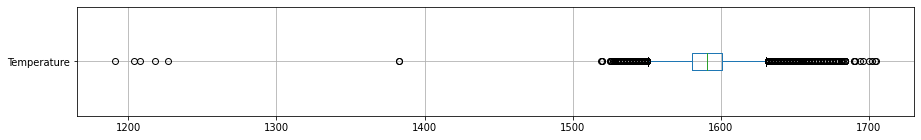

In [109]:
plt.figure(figsize=(15, 2))
data_temp.boxplot("Temperature", vert=False)
plt.show()

Здесь много значений, которые значительно меньше медианного значения

**Теперь изучим таблицу с объёмом подаваемого газа**

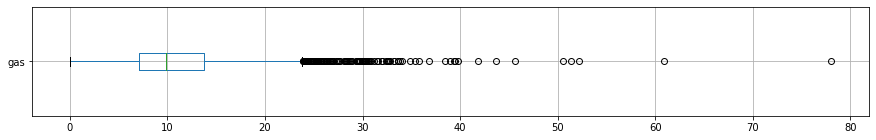

In [110]:
plt.figure(figsize=(15, 2))
data_gas.boxplot("gas", vert=False)
plt.show()

Здесь огромное количество выбросов

## Feature Engenieering

Поскольку температура наш целевой признак, то сразу выделим первую и последнюю температуру измерения

In [111]:
query = """
select key,
  "Temperature",
  first_value("Temperature") over(partition by key) as first_temp,
  last_value("Temperature") over(partition by key) as last_temp,
  (last_value("MesaureTime") over(partition by key) - 
  first_value("MesaureTime") over(partition by key)) as temp_time
from steel.data_temp
"""
data_temp = pd.read_sql_query(query, con=engine)
print(data_temp.shape)
data_temp.head()

(15907, 5)


,key,Temperature,first_temp,last_temp,temp_time
0,1,1571.0,1571.0,1613.0,0 days 00:14:21
1,1,1604.0,1571.0,1613.0,0 days 00:14:21
2,1,1618.0,1571.0,1613.0,0 days 00:14:21
3,1,1601.0,1571.0,1613.0,0 days 00:14:21
4,1,1613.0,1571.0,1613.0,0 days 00:14:21


In [112]:
data_temp = data_temp.drop("Temperature", axis=1)

In [113]:
data_temp = data_temp[data_temp['first_temp'] != data_temp['last_temp']]
data_temp.shape

(15701, 4)

In [114]:
query = """
select *,
  ("EndHeat" - "BeginHeat") as heat_time
from steel.data_arc
"""
data_arc = pd.read_sql_query(query, con=engine)
print(data_arc.shape)
data_arc.head()

(14876, 6)


,key,BeginHeat,EndHeat,ActivePower,ReactivePower,heat_time
0,1,11:02:14,11:06:02,0.976059,0.687084,0 days 00:03:48
1,1,11:07:28,11:10:33,0.805607,0.520285,0 days 00:03:05
2,1,11:11:44,11:14:36,0.744363,0.498805,0 days 00:02:52
3,1,11:18:14,11:24:19,1.659363,1.062669,0 days 00:06:05
4,1,11:26:09,11:28:37,0.692755,0.414397,0 days 00:02:28


In [115]:
data_arc = data_arc.drop(['BeginHeat', 'EndHeat'], axis=1)
print(data_arc.shape)
data_arc.head()

(14876, 4)


,key,ActivePower,ReactivePower,heat_time
0,1,0.976059,0.687084,0 days 00:03:48
1,1,0.805607,0.520285,0 days 00:03:05
2,1,0.744363,0.498805,0 days 00:02:52
3,1,1.659363,1.062669,0 days 00:06:05
4,1,0.692755,0.414397,0 days 00:02:28


In [116]:
data_bulk = data_bulk.drop(['Bulk 8', 'Bulk 15'], axis=1)
data_wire = data_wire.drop(['Wire 1', 'Wire 2','Wire 5'], axis=1)

In [117]:
data = data_arc.merge(data_bulk, on= 'key', how='left')
data = data.merge(data_gas, on='key', how='left')
data = data.merge(data_temp, on='key', how='left')
data = data.merge(data_wire, on='key', how='left')
data.dropna(axis=1)
print(data.shape)
data.head()

(77568, 27)


,key,ActivePower,ReactivePower,heat_time,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,gas,first_temp,last_temp,temp_time,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
0,1,0.976059,0.687084,0 days 00:03:48,0.0,0.0,0.0,43.0,0.0,0.0,...,29.749986,1571.0,1613.0,0 days 00:14:21,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.976059,0.687084,0 days 00:03:48,0.0,0.0,0.0,43.0,0.0,0.0,...,29.749986,1571.0,1613.0,0 days 00:14:21,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.976059,0.687084,0 days 00:03:48,0.0,0.0,0.0,43.0,0.0,0.0,...,29.749986,1571.0,1613.0,0 days 00:14:21,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0.976059,0.687084,0 days 00:03:48,0.0,0.0,0.0,43.0,0.0,0.0,...,29.749986,1571.0,1613.0,0 days 00:14:21,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0.976059,0.687084,0 days 00:03:48,0.0,0.0,0.0,43.0,0.0,0.0,...,29.749986,1571.0,1613.0,0 days 00:14:21,0.0,0.0,0.0,0.0,0.0,0.0


In [118]:
print(data.duplicated().sum())
print(data.shape)
data = data.drop_duplicates()
print('New shape - ', data.shape)
data.head()

62692
(77568, 27)
New shape -  (14876, 27)


,key,ActivePower,ReactivePower,heat_time,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,gas,first_temp,last_temp,temp_time,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
0,1,0.976059,0.687084,0 days 00:03:48,0.0,0.0,0.0,43.0,0.0,0.0,...,29.749986,1571.0,1613.0,0 days 00:14:21,0.0,0.0,0.0,0.0,0.0,0.0
5,1,0.805607,0.520285,0 days 00:03:05,0.0,0.0,0.0,43.0,0.0,0.0,...,29.749986,1571.0,1613.0,0 days 00:14:21,0.0,0.0,0.0,0.0,0.0,0.0
10,1,0.744363,0.498805,0 days 00:02:52,0.0,0.0,0.0,43.0,0.0,0.0,...,29.749986,1571.0,1613.0,0 days 00:14:21,0.0,0.0,0.0,0.0,0.0,0.0
15,1,1.659363,1.062669,0 days 00:06:05,0.0,0.0,0.0,43.0,0.0,0.0,...,29.749986,1571.0,1613.0,0 days 00:14:21,0.0,0.0,0.0,0.0,0.0,0.0
20,1,0.692755,0.414397,0 days 00:02:28,0.0,0.0,0.0,43.0,0.0,0.0,...,29.749986,1571.0,1613.0,0 days 00:14:21,0.0,0.0,0.0,0.0,0.0,0.0


In [119]:
data = data.groupby('key').mean()
print(data.shape)
data.head()

(3214, 24)


,ActivePower,ReactivePower,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 9,...,Bulk 14,gas,first_temp,last_temp,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,,,,,,,,,,,,,
1,0.975629,0.636648,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,...,150.0,29.749986,1571.0,1613.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.763150,0.499528,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,...,149.0,12.555561,1581.0,1602.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.505176,0.319815,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,...,152.0,28.554793,1596.0,1599.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.802313,0.515074,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,...,153.0,18.841219,1601.0,1625.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.836793,0.563161,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,...,151.0,5.413692,1576.0,1602.0,0.0,0.0,0.0,0.0,0.0,0.0


In [120]:
data.drop(data[data.last_temp.isna()].index, inplace=True)

In [121]:
for column in data.columns:
  if (data[column].dtypes == 'object') or (data[column].dtypes == 'timedelta64[ns]'):
    data[column] = data[column].fillna(pd.Timedelta(seconds=0))
  else:
    data[column] = data[column].fillna(0)
print(data.shape)
data.isna().sum()

(2433, 24)


ActivePower      0
ReactivePower    0
Bulk 1           0
Bulk 2           0
Bulk 3           0
Bulk 4           0
Bulk 5           0
Bulk 6           0
Bulk 7           0
Bulk 9           0
Bulk 10          0
Bulk 11          0
Bulk 12          0
Bulk 13          0
Bulk 14          0
gas              0
first_temp       0
last_temp        0
Wire 3           0
Wire 4           0
Wire 6           0
Wire 7           0
Wire 8           0
Wire 9           0
dtype: int64

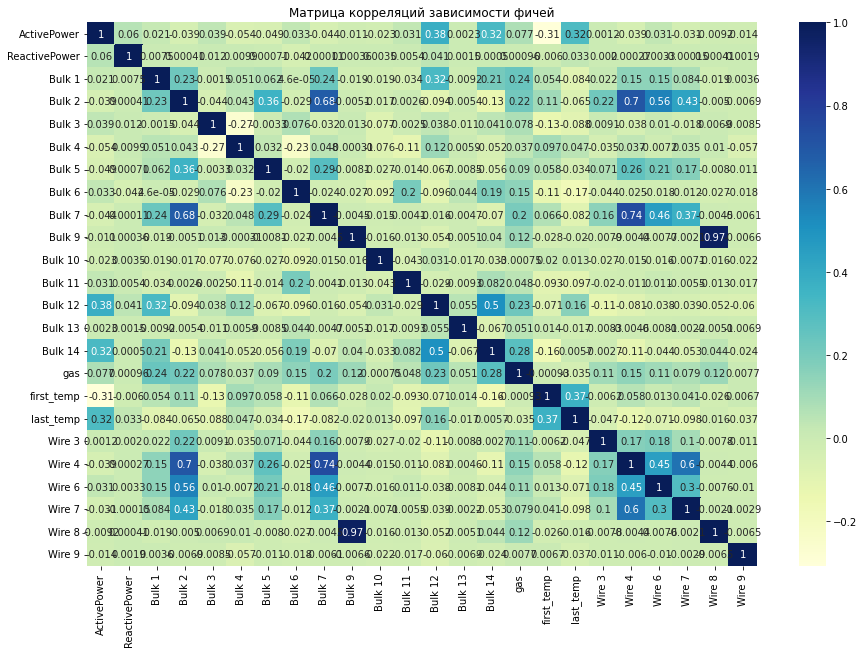

In [122]:
plt.figure(figsize=(15, 10))
plt.title('Матрица корреляций зависимости фичей')

sns.heatmap(data.corr(), annot = True, cmap="YlGnBu")

plt.show()

Необходимо удалить сильно-коррелирующие признаки (корреляция больше 0,8 )

In [123]:
data = data.drop(['Bulk 9', 'Wire 8'], axis=1)

In [124]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2433 entries, 1 to 2499
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ActivePower    2433 non-null   float64
 1   ReactivePower  2433 non-null   float64
 2   Bulk 1         2433 non-null   float64
 3   Bulk 2         2433 non-null   float64
 4   Bulk 3         2433 non-null   float64
 5   Bulk 4         2433 non-null   float64
 6   Bulk 5         2433 non-null   float64
 7   Bulk 6         2433 non-null   float64
 8   Bulk 7         2433 non-null   float64
 9   Bulk 10        2433 non-null   float64
 10  Bulk 11        2433 non-null   float64
 11  Bulk 12        2433 non-null   float64
 12  Bulk 13        2433 non-null   float64
 13  Bulk 14        2433 non-null   float64
 14  gas            2433 non-null   float64
 15  first_temp     2433 non-null   float64
 16  last_temp      2433 non-null   float64
 17  Wire 3         2433 non-null   float64
 18  Wire 4  

## Model Fitting

In [125]:
features = data.drop('last_temp', axis=1)
target = data['last_temp']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=42)

In [126]:
features.shape

(2433, 21)

**Обучим модель RandomForest**

In [127]:
start_time = time.time()
ran_grid_forest = {
    'max_depth': list(range(2, 9)),
    'n_estimators': [50, 100, 200, 300]
}

rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = ran_grid_forest, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1, scoring='neg_mean_absolute_error')

rf_random.fit(features_train, target_train)
print("--- %s seconds ---" % (time.time() - start_time))
print('Best score - ', rf_random.best_score_ * (-1))

Fitting 3 folds for each of 28 candidates, totalling 84 fits
--- 34.66842007637024 seconds ---
Best score -  7.42099827492476


Исправил

**Обучим модель CatboostRegressor**

In [128]:
start_time = time.time()
cat = CatBoostRegressor(verbose=False, eval_metric= 'MAE') 

parameters = {'iterations': [100, 250, 500],
              'depth': [1, 2, 3, 4],
              'l2_leaf_reg': [0.2, 0.5, 1],
              'learning_rate': [0.001, 0.1, 0.5]
}

grid_search_result = cat.grid_search(parameters, 
                                           X=features_train, 
                                           y=target_train, 
                                           plot=False)
print("--- %s seconds ---" % (time.time() - start_time))


bestTest = 1442.965138
bestIteration = 99

0:	loss: 1442.9651382	best: 1442.9651382 (0)	total: 55ms	remaining: 5.88s

bestTest = 8.778061465
bestIteration = 99

1:	loss: 8.7780615	best: 8.7780615 (1)	total: 94.9ms	remaining: 5.03s

bestTest = 8.487366844
bestIteration = 77

2:	loss: 8.4873668	best: 8.4873668 (2)	total: 149ms	remaining: 5.22s

bestTest = 1443.027116
bestIteration = 99

3:	loss: 1443.0271160	best: 8.4873668 (2)	total: 199ms	remaining: 5.17s

bestTest = 8.842761516
bestIteration = 96

4:	loss: 8.8427615	best: 8.4873668 (2)	total: 240ms	remaining: 4.95s

bestTest = 8.498326505
bestIteration = 68

5:	loss: 8.4983265	best: 8.4873668 (2)	total: 283ms	remaining: 4.81s

bestTest = 1443.128518
bestIteration = 99

6:	loss: 1443.1285181	best: 8.4873668 (2)	total: 320ms	remaining: 4.62s

bestTest = 8.886968882
bestIteration = 99

7:	loss: 8.8869689	best: 8.4873668 (2)	total: 361ms	remaining: 4.51s

bestTest = 8.716219844
bestIteration = 65

8:	loss: 8.7162198	best: 8.4873668 (2)	t

In [129]:
catboost = CatBoostRegressor(**grid_search_result.get('params'), verbose=0) 
catboost.fit(features_train, target_train)
print('CatBoost best score - ', catboost.get_best_score())

CatBoost best score -  {'learn': {'RMSE': 6.9606604229053515}}


Теперь обучим полносвязанную нейронную сеть

In [132]:
model = Sequential()
model.add(Dense(256, input_shape=(21,)))
model.add(Dense(64))
model.add(Dense(32))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam', metrics='mae')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 256)               5632      
                                                                 
 dense_9 (Dense)             (None, 64)                16448     
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 24,193
Trainable params: 24,193
Non-trainable params: 0
_________________________________________________________________


In [133]:
print("Fit model on training data")
start_time = time.time()
history = model.fit(
    features_train,
    target_train,
    batch_size=32,
    epochs=100,
    verbose=0
)
print("--- %s seconds ---" % (time.time() - start_time))

Fit model on training data
--- 20.870895862579346 seconds ---


In [134]:
print('Test MAE - ', mean_absolute_error(target_test, model.predict(features_test)))

23/23 [==============================] - 0s 2ms/step
Test MAE -  23.785003912938784


**Итоговая проверка**

In [135]:
random_forest = RandomForestRegressor(**rf_random.best_params_)
random_forest.fit(features_train, target_train)
print('MAE - ', mean_absolute_error(target_test, random_forest.predict(features_test)))

MAE -  7.309914325214951


In [136]:
print('MAE - ', mean_absolute_error(target_test, catboost.predict(features_test)))

MAE -  7.343563157678071


Итак, на тестовых данных лучше всего себя показала модель CatBoostRegressor. Она отлично генерализирует данные и  прогнозирует целевую переменную со средней абсолютной ошибкой в 7,34

## Feature Importance

Теперь с помощью лучшей модели попробуем изучить вклад каждого признака в итоговую модель 

Text(0.5, 1.0, 'Feature Importance')

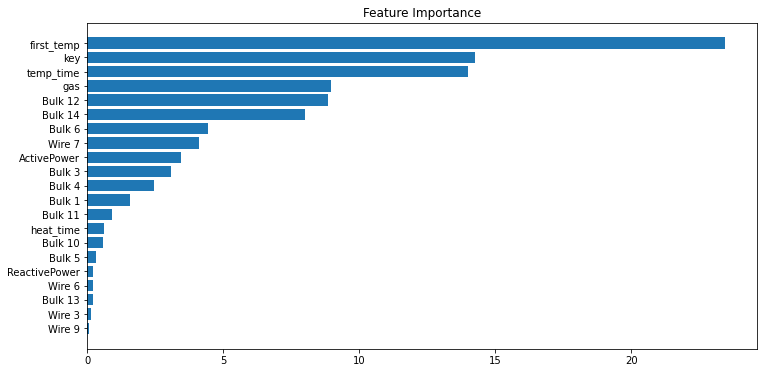

In [ ]:
feature_importance = catboost.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features_test.columns)[sorted_idx])
plt.title('Feature Importance')


Итак, как мы можем наблюдать основными признаками являются: 
1. температура при первом измерении;
2. время между первым и последним измерением температуры
3. объем поданного газа;

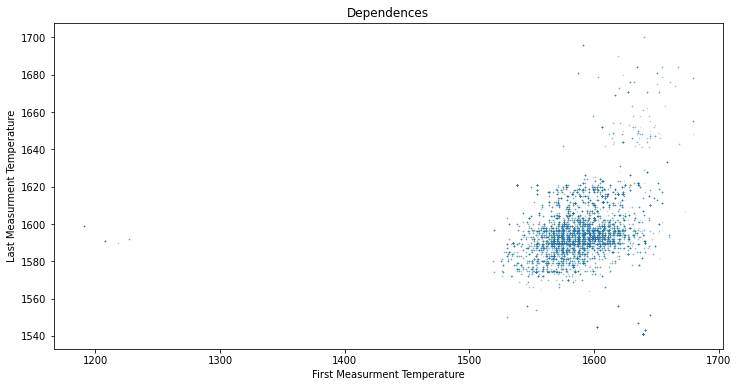

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data['first_temp'], data['last_temp'], 'o',
         alpha=0.02, markersize=1)

plt.xlabel('First Measurment Temperature')
plt.ylabel('Last Measurment Temperature')
plt.title('Dependences')
plt.show();

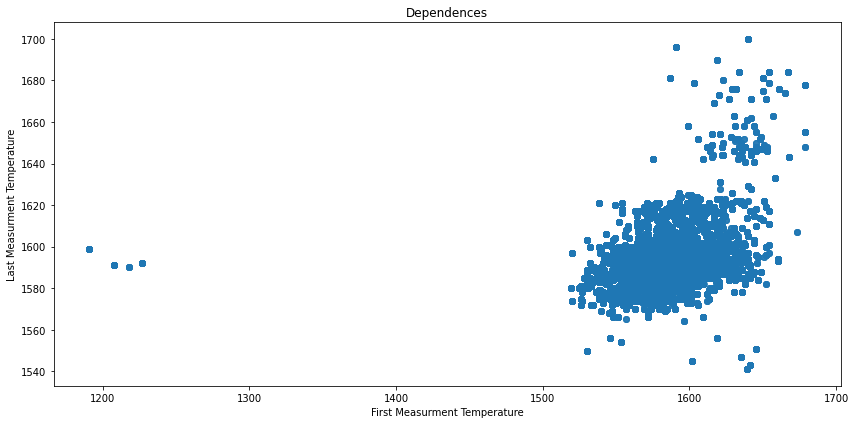

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(data['first_temp'], data['last_temp'], 'o', alpha=0.5)
plt.xlabel('First Measurment Temperature')
plt.ylabel('Last Measurment Temperature')
plt.title('Dependences')
plt.tight_layout()
plt.show();

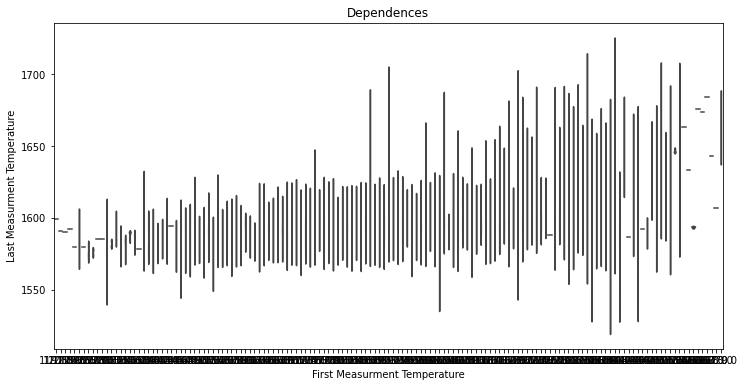

In [ ]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='first_temp', y='last_temp', data=data, inner=None)

plt.xlabel('First Measurment Temperature')
plt.ylabel('Last Measurment Temperature')
plt.title('Dependences')
plt.show();

Итак, можно сделать вывод, что между этими двумя переменными нет прямой линейной зависиомсти. 

## Conclusion

Подводя итоги можно отметить, что: 
1. Все этапы работы проделена, никаких серьезных ошибок не было
2. Была проведена предобработка данных, а так же подготовка данных для последующего обучения моделей
3. Лучшим образом себя показала модель CatBoostRegressor, на тестовой выборке ее результат MAE - 1.98
4. Была рассмотрена взаимосвязь между одной из ключевых признаков и целевой переменной